In [ ]:
## The goal of this notebook is to analyze the tweets from the Sept. 26 and Oct. 9 2016 US Presidential Debates

In [2]:
## import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from collections import Counter
import scipy.sparse
from prettytable import PrettyTable
import gc

## display the plots inline
%matplotlib inline

## load the processed test-set tweets
df_test = pd.read_pickle('tweet_data/test_data/debate_data/debate_data_processed.pkl')
print 'test data set size:', len(df_test)

## load the Naive Bayes and the MaxEnt models
lambda_neg = np.load('model_parameters/lambda_neg.npy')
lambda_neutral = np.load('model_parameters/lambda_neutral.npy')
lambda_pos = np.load('model_parameters/lambda_pos.npy')
feature = np.load('model_parameters/feature.npy')
words_unique = list(np.load('model_parameters/words_unique.npy'))
max_rank = len(words_unique)

test data set size: 95322


In [3]:
## convert word list to word rank list
def word_to_rank(x):
  return sorted([ words_unique.index(w) for w in x if w in words_unique])

## create the sparse feature matrices
def feature_matrix(df):
  feature = scipy.sparse.lil_matrix((len(df), max_rank))
  for j in range(len(df)):
    for i in range(len(df['word_ranks'].iloc[j])):
      feature[j, df['word_ranks'].iloc[j][i]] += 1.0/(len(df['word_ranks'].iloc[j]))
  return scipy.sparse.csr_matrix(feature) ## convert into csr matrix

## prediction accuracy
def ME_predictions(df, feature, lambda_neg, lambda_neutral, lambda_pos):
  flambda_neg = feature.dot(lambda_neg)
  flambda_neutral = feature.dot(lambda_neutral)
  flambda_pos = feature.dot(lambda_pos)
  boltz_neg = np.squeeze(np.asarray(np.exp(flambda_neg)))
  boltz_neutral = np.squeeze(np.asarray(np.exp(flambda_neutral)))
  boltz_pos = np.squeeze(np.asarray(np.exp(flambda_pos)))
  predict = []
  for i in range(len(df)):
    p_neg = boltz_neg[i]
    p_neutral = boltz_neutral[i]
    p_pos = boltz_pos[i]
    predict.append(-1 + [p_neg, p_neutral, p_pos].index(max([p_neg, p_neutral, p_pos])))
  return predict

df_test['word_ranks'] = df_test['words'].map(word_to_rank)
feature_test = feature_matrix(df_test)
testpred = ME_predictions(df_test, feature_test, lambda_neg, lambda_neutral, lambda_pos)
df_test['predictions'] = testpred

In [4]:
print 'Sept. 26 Debate'
print 'sentiment:', 1.0*sum(df_test[df_test['event date']=='sept26']['predictions'])/len(df_test[df_test['event date']=='sept26'])
print ' positive:', 1.0*sum(df_test[df_test['event date']=='sept26']['predictions']==1)/len(df_test[df_test['event date']=='sept26'])
print ' neutral:', 1.0*sum(df_test[df_test['event date']=='sept26']['predictions']==0)/len(df_test[df_test['event date']=='sept26'])
print ' negative:', 1.0*sum(df_test[df_test['event date']=='sept26']['predictions']==-1)/len(df_test[df_test['event date']=='sept26'])

print 'Oct. 9 Debate'
print 'sentiment:', 1.0*sum(df_test[df_test['event date']=='oct09']['predictions'])/len(df_test[df_test['event date']=='oct09'])
print ' positive:', 1.0*sum(df_test[df_test['event date']=='oct09']['predictions']==1)/len(df_test[df_test['event date']=='oct09'])
print ' neutral:', 1.0*sum(df_test[df_test['event date']=='oct09']['predictions']==0)/len(df_test[df_test['event date']=='oct09'])
print ' negative:', 1.0*sum(df_test[df_test['event date']=='oct09']['predictions']==-1)/len(df_test[df_test['event date']=='oct09'])

Sept. 26 Debate
sentiment: 0.0742594910305
 positive: 0.362974551523
 neutral: 0.348310387985
 negative: 0.288715060492
Oct. 9 Debate
sentiment: 0.1117301929
 positive: 0.397492718754
 neutral: 0.316744755392
 negative: 0.285762525854


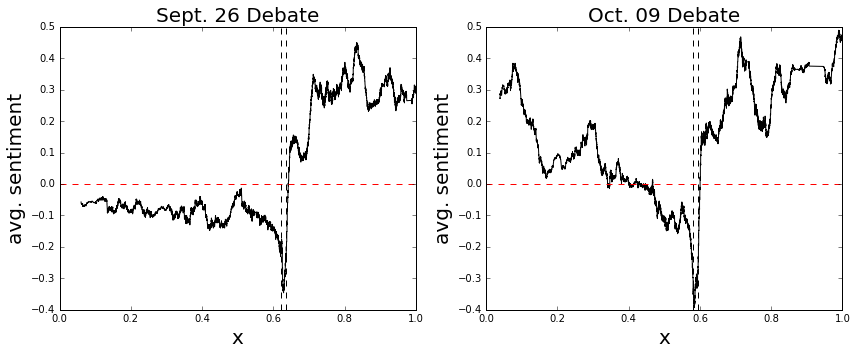

In [6]:
## Plot the moving average for the sentiment of each debate

## convert the id to a number from 0 to 1
def xid(df, eventdate):
  return np.asarray(1.0*(df[df['event date'] == eventdate]['id'] - df[df['event date'] == eventdate]['id'].iloc[0]) \
  /(df[df['event date'] == eventdate]['id'].iloc[-1] - df[df['event date'] == eventdate]['id'].iloc[0]))
xid_sept26 = xid(df_test, 'sept26')
xid_oct09 = xid(df_test, 'oct09')

## the sentiment values  
def yvalue(df, eventdate, win):
  return np.asarray(df[df['event date'] == eventdate]['predictions'].rolling(window=win,center=False).mean())
win = 1000
y_sept26 = yvalue(df_test, 'sept26', win)
y_oct09 = yvalue(df_test, 'oct09', win)

## find out when the debates began and ended (1am UTC time)
id_sept26start = df_test['id'].iloc[df_test[df_test['created_at'].str.contains("Tue Sep 27 01:01")].index[0]]
id_sept26end = df_test['id'].iloc[df_test[df_test['created_at'].str.contains("Tue Sep 27 02:31")].index[0]]
id_oct09start = df_test['id'].iloc[df_test[df_test['created_at'].str.contains("Mon Oct 10 01:01")].index[0]]
id_oct09end = df_test['id'].iloc[df_test[df_test['created_at'].str.contains("Mon Oct 10 02:31")].index[0]]

## find the xid value of a specific id
def xid_specific(df, eventdate, specific_id):
  return 1.0*(specific_id - df[df['event date'] == eventdate]['id'].iloc[0]) \
  /(df[df['event date'] == eventdate]['id'].iloc[-1] - df[df['event date'] == eventdate]['id'].iloc[0])
x_sept26start = xid_specific(df_test, 'sept26', id_sept26start)
x_sept26end = xid_specific(df_test, 'sept26', id_sept26end)
x_oct09start = xid_specific(df_test, 'oct09', id_oct09start)
x_oct09end = xid_specific(df_test, 'oct09', id_oct09end)

## make the plots
fig = plt.figure(figsize=(12, 5))
## subplot 1
sub1 = fig.add_subplot(121)
sub1.set_title('Sept. 26 Debate', fontsize=20)
sub1.plot(xid_sept26, y_sept26, c='black')
sub1.set_xlabel('x', fontsize=20)
sub1.set_ylabel('avg. sentiment', fontsize=20)
sub1.axvline(x_sept26start, color='k', linestyle='--')
sub1.axvline(x_sept26end, color='k', linestyle='--')
sub1.plot(np.zeros(2), 'r--')
## subplot 2
sub2 = fig.add_subplot(122)
sub2.set_title('Oct. 09 Debate', fontsize=20)
sub2.plot(xid_oct09, y_oct09, c='black')
sub2.set_xlabel('x', fontsize=20)
sub2.set_ylabel('avg. sentiment', fontsize=20)
sub2.axvline(x_oct09start, color='k', linestyle='--')
sub2.axvline(x_oct09end, color='k', linestyle='--')
sub2.plot(np.zeros(2), 'r--')
## finish up
plt.tight_layout()
plt.savefig('figures/DebateAvgSent.png')
plt.show()

In [7]:
## examine tweets that mention just Clinton or just Trump
HRCwords = [u'hrc', u'hillary', u'clinton', u'hashtagtokenhillaryclinton', u'hashtagtokenhillary']
DJTwords = [u'donald', u'trump', u'hashtagtokendonaldtrump', u'hashtagtokentrumppence']

def in_list(list_to_search, terms_to_search, terms_to_exclude):
    pos_results = [item for item in list_to_search if item in terms_to_search]
    neg_results = [item for item in list_to_search if item in terms_to_exclude]
    if len(pos_results) > 0 and len(neg_results) == 0:
        return True
    else:
        return False


print 'Trump only sentiment, Sept. 26:', 1.0*sum(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, HRCwords))) & (df_test['event date'] == 'sept26')]['predictions']) \
  / len( df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, HRCwords))) & (df_test['event date'] == 'sept26')] )
  
print 'Clinton only sentiment, Sept. 26:', 1.0*sum(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'sept26')]['predictions']) \
  / len( df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'sept26')] )
  
print 'Trump only sentiment, Oct. 9:', 1.0*sum(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, HRCwords))) & (df_test['event date'] == 'oct09')]['predictions']) \
  / len( df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, HRCwords))) & (df_test['event date'] == 'oct09')] )
  
print 'Clinton only sentiment, Oct. 9:', 1.0*sum(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'oct09')]['predictions']) \
  / len( df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'oct09')] )

Trump only sentiment, Sept. 26: -0.179564691657
Clinton only sentiment, Sept. 26: -0.160839160839
Trump only sentiment, Oct. 9: -0.17671009772
Clinton only sentiment, Oct. 9: -0.167841409692


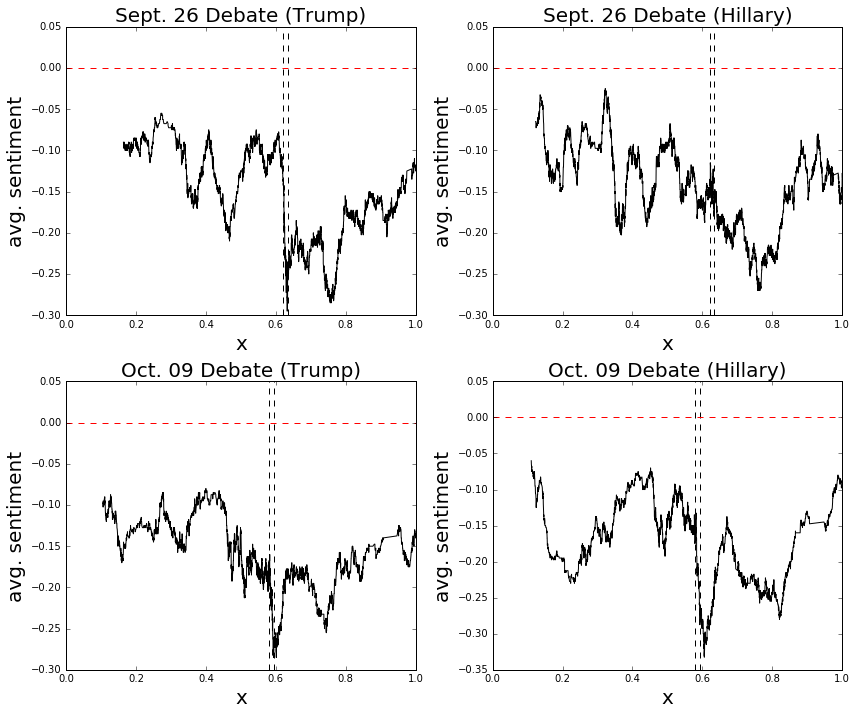

In [8]:
## Plot the moving average for the sentiment of each debate, 
## restricting to tweets mentioning only Trump or only Hillary

## convert the id to a number from 0 to 1
xid_sept26_trump = xid(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'sept26')], 'sept26')
xid_oct09_trump = xid(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'oct09')], 'oct09')
xid_sept26_hillary = xid(df_test[(df_test['words'].apply(lambda x: in_list(x, HRCwords, []))) & (df_test['event date'] == 'sept26')], 'sept26')
xid_oct09_hillary = xid(df_test[(df_test['words'].apply(lambda x: in_list(x, HRCwords, []))) & (df_test['event date'] == 'oct09')], 'oct09')

## the sentiment values
win = 400
y_sept26_trump = yvalue(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'sept26')], 'sept26', win)
y_oct09_trump = yvalue(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'oct09')], 'oct09', win)
y_sept26_hillary = yvalue(df_test[(df_test['words'].apply(lambda x: in_list(x, HRCwords, []))) & (df_test['event date'] == 'sept26')], 'sept26', win)
y_oct09_hillary = yvalue(df_test[(df_test['words'].apply(lambda x: in_list(x, HRCwords, []))) & (df_test['event date'] == 'oct09')], 'oct09', win)

## find the xid value of a specific id
x_sept26start_trump = xid_specific(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'sept26')], 'sept26', id_sept26start)
x_sept26end_trump = xid_specific(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'sept26')], 'sept26', id_sept26end)
x_oct09start_trump = xid_specific(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'oct09')], 'oct09', id_oct09start)
x_oct09end_trump = xid_specific(df_test[(df_test['words'].apply(lambda x: in_list(x, DJTwords, []))) & (df_test['event date'] == 'oct09')], 'oct09', id_oct09end)
x_sept26start_hillary = xid_specific(df_test[(df_test['words'].apply(lambda x: in_list(x, HRCwords, []))) & (df_test['event date'] == 'sept26')], 'sept26', id_sept26start)
x_sept26end_hillary = xid_specific(df_test[(df_test['words'].apply(lambda x: in_list(x, HRCwords, []))) & (df_test['event date'] == 'sept26')], 'sept26', id_sept26end)
x_oct09start_hillary = xid_specific(df_test[(df_test['words'].apply(lambda x: in_list(x, HRCwords, []))) & (df_test['event date'] == 'oct09')], 'oct09', id_oct09start)
x_oct09end_hillary = xid_specific(df_test[(df_test['words'].apply(lambda x: in_list(x, HRCwords, []))) & (df_test['event date'] == 'oct09')], 'oct09', id_oct09end)


## make the plots
fig = plt.figure(figsize=(12, 10))
## subplot 1
sub1 = fig.add_subplot(221)
sub1.set_title('Sept. 26 Debate (Trump)', fontsize=20)
sub1.plot(xid_sept26_trump, y_sept26_trump, c='black')
sub1.set_xlabel('x', fontsize=20)
sub1.set_ylabel('avg. sentiment', fontsize=20)
sub1.axvline(x_sept26start_trump, color='k', linestyle='--')
sub1.axvline(x_sept26end_trump, color='k', linestyle='--')
sub1.plot(np.zeros(2), 'r--')
## subplot 2
sub2 = fig.add_subplot(222)
sub2.set_title('Sept. 26 Debate (Hillary)', fontsize=20)
sub2.plot(xid_sept26_hillary, y_sept26_hillary, c='black')
sub2.set_xlabel('x', fontsize=20)
sub2.set_ylabel('avg. sentiment', fontsize=20)
sub2.axvline(x_sept26start_hillary, color='k', linestyle='--')
sub2.axvline(x_sept26end_hillary, color='k', linestyle='--')
sub2.plot(np.zeros(2), 'r--')
## subplot 3
sub3 = fig.add_subplot(223)
sub3.set_title('Oct. 09 Debate (Trump)', fontsize=20)
sub3.plot(xid_oct09_trump, y_oct09_trump, c='black')
sub3.set_xlabel('x', fontsize=20)
sub3.set_ylabel('avg. sentiment', fontsize=20)
sub3.axvline(x_oct09start_trump, color='k', linestyle='--')
sub3.axvline(x_oct09end_trump, color='k', linestyle='--')
sub3.plot(np.zeros(2), 'r--')
## subplot 4
sub4 = fig.add_subplot(224)
sub4.set_title('Oct. 09 Debate (Hillary)', fontsize=20)
sub4.plot(xid_oct09_hillary, y_oct09_hillary, c='black')
sub4.set_xlabel('x', fontsize=20)
sub4.set_ylabel('avg. sentiment', fontsize=20)
sub4.axvline(x_oct09start_hillary, color='k', linestyle='--')
sub4.axvline(x_oct09end_hillary, color='k', linestyle='--')
sub4.plot(np.zeros(2), 'r--')
## finish up
plt.tight_layout()
plt.savefig('figures/DebateAvgSent_candidatespecific.png')
plt.show()